In [1]:
import numpy as np
from cleaning import clean_data, SMOTE_resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier

In [2]:
# Load Data
X_train, y_train, X_test, y_test = clean_data('')

# SMOTE Resample
X_train, y_train = SMOTE_resample(X_train, y_train)

In [4]:
# KNN Classifier
nn = [5, 15, 25, 35]
leaf_sizes = [20, 30, 40]

random_grid = {
    "n_neighbors": nn,
    "leaf_size": leaf_sizes,
}

kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')
knn = KNeighborsClassifier(p=1, weights='distance')
knn_random = RandomizedSearchCV(estimator=knn, param_distributions=random_grid, n_iter=6, cv=5, verbose=0, n_jobs=-1, error_score=np.NINF, scoring=kappa_scorer)
knn_random.fit(X_train, y_train)
print(f'Best Parameters = {knn_random.best_params_}')
print(f'Best Score = {knn_random.best_score_}')

Best Parameters = {'n_neighbors': 5, 'leaf_size': 20}
Best Score = 0.6287348495451137


In [5]:
# Best parameters
best_params = {'n_neighbors': 5, 'leaf_size': 20}
# best_params = knn_random.best_params_
knn = KNeighborsClassifier(weights='distance', p=1, n_neighbors=best_params['n_neighbors'], leaf_size=best_params['leaf_size'])
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f'Train Score = {knn.score(X_train, y_train)}')
print(f'Test Score = {knn.score(X_test, y_test)}')
kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f'Cohens Kappa Score = {kappa}')


Train Score = 0.9897243960530793
Test Score = 0.31658514895509116
Cohens Kappa Score = 0.1550989423671595


In [14]:
# Feature selection
# PCA
pca = PCA(n_components=15, svd_solver='full')
pcaX_train = pca.fit_transform(X_train)
pcaX_test = pca.transform(X_test)

# Select K Best
kb = SelectKBest()
kbX_train = kb.fit_transform(X_train, y_train)
kbX_test = kb.transform(X_test)

# Variance Threshold
vt = VarianceThreshold(threshold=(.8 * (1 - .8)))
vtX_train = vt.fit_transform(X_train, y_train)
vtX_test = vt.transform(X_test)

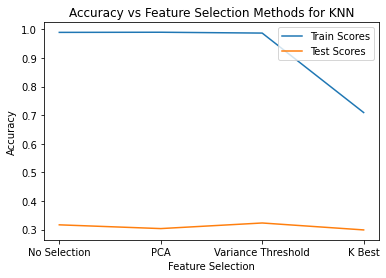

In [15]:
# Feature Selection
dataLabels = ['No Selection', 'PCA', 'Variance Threshold', 'K Best']
data = [(X_train, X_test), (pcaX_train, pcaX_test), (vtX_train, vtX_test), (kbX_train, kbX_test)]

trainScores = []
testScores = []
for i, label in enumerate(dataLabels):
    xtrain, xtest = data[i]
    knn = KNeighborsClassifier(weights='distance', p=1, n_neighbors=5, leaf_size=20)
    knn.fit(xtrain, y_train)
    trainScores.append(knn.score(xtrain, y_train))
    testScores.append(knn.score(xtest, y_test))

plt.plot(dataLabels, trainScores, label='Train Scores')
plt.plot(dataLabels, testScores, label='Test Scores')
plt.title(f'Accuracy vs Feature Selection Methods for KNN')
plt.xlabel('Feature Selection')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

In [18]:
# Retrain KNN Classifier with PCA
knn = KNeighborsClassifier(weights='distance', p=1, n_neighbors=5, leaf_size=20)
knn.fit(pcaX_train, y_train)
y_pred = knn.predict(pcaX_test)
print(f'Train Score = {knn.score(pcaX_train, y_train)}')
print(f'Test Score = {knn.score(pcaX_test, y_test)}')
kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f'Cohens Kappa Score = {kappa}')

Train Score = 0.9902007485539299
Test Score = 0.30346820809248554
Cohens Kappa Score = 0.1619132195055275


In [17]:
# Bagging Classifier (probably isnt great)
bc = BaggingClassifier(base_estimator=knn, n_estimators=20, n_jobs=-1)
bc.fit(pcaX_train, y_train)
y_pred = bc.predict(pcaX_test)
print(f'Train Score = {bc.score(pcaX_train, y_train)}')
print(f'Test Score = {bc.score(pcaX_test, y_test)}')
kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f'Cohens Kappa Score = {kappa}')

Train Score = 0.9869343314052399
Test Score = 0.30902623388172523
Cohens Kappa Score = 0.1697706789041784
